In [2]:
# std packages
%matplotlib inline
import numpy as np
import scipy.interpolate as interp
import scipy.signal as sig
import scipy.optimize as opt
import scipy.integrate as integ
import scipy.linalg as sla
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import h5py as h5

plt.rc('figure', figsize=(9, 7))
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.serif': ['Georgia'],
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 2.5,
                     'font.size': 20,
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'axes.grid': False,
                     'grid.alpha': 0.5,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 17,
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.bbox': 'tight',
                     'savefig.pad_inches': 0.05,
                     'savefig.dpi': 80,
                     'pdf.compression': 9})
from myConstants import *

In [3]:
def evol_log_aL(t_nat, logy_vect, par_aL):
    loga, logL = logy_vect
    M1, M2, t_unit= par_aL
    Mt=M1+M2
    mu=M1*M2/Mt
    
    a_orb = np.exp(loga)
    L_orb = np.exp(logL)
    eff = L_orb/(mu*np.sqrt(G*Mt*a_orb))
    e_orb = np.sqrt(1.-eff**2.)
    
    G3_c5 = G**3./c**5.
    e2 = e_orb**2.
    e4 = e_orb**4.
    
    da = - (64./5.*G3_c5) * (mu*(M1+M2)**2./(a_orb**3.))\
          * (1. + 73./24.*e2 + 37./96.*e4)/(eff**7.)    
    dL = - (32./5.*G3_c5*np.sqrt(G)) * mu**2.*(M1+M2)**2.5 / (a_orb**3.5) \
          * (1.+0.875*e2)/(eff**4.)
    
    dlogy_vect = np.array([da/a_orb, dL/L_orb]) * t_unit
    return dlogy_vect

In [4]:
def get_inst_t_gw_from_a_orb(M1, M2, a_orb, e):
    Mt=M1+M2
    mu=M1*M2/(M1+M2)
    inv_t_gw = (64./5.)*(G**3./c**5.)*mu*Mt**2./a_orb**4. \
                * (1.+73./24.*e**2+37./96.*e**4.)/(1.-e**2.)**(3.5)
    t_gw = 1./inv_t_gw
    return t_gw

def get_angles(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    
    c_th1 = 0.5 * 1./((1.-qq)*S1) * \
        ((J**2. - L**2. - S**2.)/L  - 2.*qq*G*Mt**2./c*chi_eff/(1.+qq))
    c_th2 = 0.5 * qq/((1.-qq)*S2) * \
        (-(J**2.-L**2.-S**2.)/L + 2.*G*Mt**2./c*chi_eff/(1.+qq))
    c_th12 = (S**2. - S1**2. -S2**2.)/(2.*S1*S2)
    
    th1, th2, th12 = np.arccos(c_th1), np.arccos(c_th2), np.arccos(c_th12)
    c_dphi = (c_th12 - c_th1*c_th2)/(np.sin(th1) * np.sin(th2))
    dphi = np.arccos(c_dphi)
    return th1, th2, th12, dphi

def get_dSdt(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    mu=M1*M2/Mt
    eta=mu/Mt
    eff = np.sqrt(1.-e**2.)
    
    th1, th2, th12, dphi = get_angles(J, L, e, S, par)
    
    dSdt = 1.5*eta**6. * eff**3. * (1-qq**2.)/qq * ((G*Mt**2./c)/L)**5.\
        * (c**3./G/Mt) * (S1*S2/S)\
        * (-1. + 0.5*qq/(1.-qq)**2.*(J**2.-L**2.-S**2.)/L**2. \
          - 2.*qq**2./(1.-qq**2.)**2.*G*Mt**2./c/L*chi_eff)\
        * np.sin(th1) * np.sin(th2) * np.sin(dphi)
    return dSdt

def find_Smp(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    # note here is S vs chi-chi_eff!
    chi_vs_S_func1 = interp.interp1d(S_vect, chi_vect1-chi_eff)
    chi_vs_S_func2 = interp.interp1d(S_vect, chi_vect2-chi_eff)
    
    idx1 = np.argmin(chi_vect1)
    idx2 = np.argmax(chi_vect2)
    
    if np.max(chi_vect1) < chi_eff:
        Sm = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
        Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
    elif np.min(chi_vect2) > chi_eff:
        Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        Sp = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
    else:
        try:
            Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        except ValueError:
            Sm = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
        try:
            Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
        except ValueError:
            Sp = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
            
    if Sm>Sp:
        Sm, Sp = Sp, Sm
    return Sm, Sp
    
def find_S_chi_contour(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    return S_vect, chi_vect1, chi_vect2
    
def get_tau_pre(J, L, e, par, nPt=500):
    M1, M2, S1, S2, chi_eff = par

    Sm, Sp = find_Smp(J, L, e, par)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = get_dSdt(J, L, e, S_vect, par)
    tau_pre = 2.*integ.trapz(1./np.abs(dSdt_vect), S_vect)
    return tau_pre    

def evol_J_avg(L_nat, J_nat, e_vs_L_func, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    
    Mt=M1+M2
    mu=M1*M2/Mt
    eta = M1*M2/Mt**2.
    
    r_Mt = G*Mt/c**2.
    S_Mt = G*Mt**2./c
    
    L=L_nat * S_Mt
    J=J_nat * S_Mt
    
    e_orb = e_vs_L_func(L)
    a_orb = L**2./(G*mu**2.*Mt*(1.-e_orb**2.))
    
    t_gw = get_inst_t_gw_from_a_orb(M1, M2, a_orb, e_orb)
    
    Sm, Sp = find_Smp(J, L, e_orb, par, nPt=nPt)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = np.abs(get_dSdt(J, L, e_orb, S_vect, par))
    
    inv_t_pre = np.abs(dSdt_vect/(S_vect+1.e-9*np.ones(nPt)*S_Mt))
    if np.min(inv_t_pre)<(1./t_gw):
        idx = np.argmin(inv_t_pre)
        S = S_vect[idx]
        c_th_L = (J**2.+L**2.-S**2.)/(2*J*L)
        dJdL = c_th_L
    else:
        c_th_L = (J**2.+L**2.-S_vect**2.)/(2*J*L)
        tau = 2.*integ.trapz(S_Mt/dSdt_vect, S_vect/S_Mt)
        dJdL = 2./tau * integ.trapz(S_Mt*c_th_L/dSdt_vect, S_vect/S_Mt)
    return dJdL

In [5]:
fig_dir = '/home/hang.yu/public_html/astro/LK_evol/test/'
data_dir = 'data/'
prefix = 'seg4_'

fid=h5.File(data_dir + prefix + 'data.h5', 'r')
M1, M2= fid.attrs['M1'], fid.attrs['M2']
Mt = M1 + M2
mu=M1*M2/(M1+M2)
qq=M2/M1
eta = mu/Mt

chi1, chi2 = fid.attrs['chi1'], fid.attrs['chi2']

t = fid['t'][()]
t -= t[0]
ai = fid['ai'][()]
Li_x, Li_y, Li_z = fid['Li_x'][()], fid['Li_y'][()], fid['Li_z'][()]
Li = np.sqrt(Li_x**2. + Li_y**2. + Li_z**2.)

ei_x, ei_y, ei_z = fid['ei_x'][()], fid['ei_y'][()], fid['ei_z'][()]
ei = np.sqrt(ei_x**2. + ei_y**2. + ei_z**2.)
eff_i = np.sqrt(1.-ei**2.)

S1_x, S1_y, S1_z = fid['S1_x'][()], fid['S1_y'][()], fid['S1_z'][()]
S1 = np.sqrt(S1_x**2. + S1_y**2. + S1_z**2.)
S1 = np.median(S1)

S2_x, S2_y, S2_z = fid['S2_x'][()], fid['S2_y'][()], fid['S2_z'][()]
S2 = np.sqrt(S2_x**2. + S2_y**2. + S2_z**2.)
S2 = np.median(S2)
fid.close()

print(ei[0], ei[-1])

print(len(t))

# idx = (ei>0.897) & (ei<0.953)
# t = t[idx]
# t-=t[0]
# ai = ai[idx]
# Li_x, Li_y, Li_z = Li_x[idx], Li_y[idx], Li_z[idx]
# Li = Li[idx]

# ei_x, ei_y, ei_z = ei_x[idx], ei_y[idx], ei_z[idx]
# ei = ei[idx]
# eff_i = eff_i[idx]

# S1_x, S1_y, S1_z = S1_x[idx], S1_y[idx], S1_z[idx]
# S1 = S1[idx]

# S2_x, S2_y, S2_z = S2_x[idx], S2_y[idx], S2_z[idx]
# S2 = S2[idx]

0.18055828261333307 0.004969483721268652
3177868


In [6]:
inv_t_gw = (64./5.)*(G**3./c**5.)*mu*Mt**2./ai[0]**4. \
            * (1.+73./24.*ei[0]**2+37./96.*ei[0]**4.)/(1.-ei[0]**2.)**(3.5)
t_gw = 1./inv_t_gw
print((t[-1]-t[0])/t_gw)

omega_orb = np.sqrt(G*Mt/ai[0]**3.)
omega_pre = omega_orb * G*Mt/(c**2.*ai[0]*eff_i[0]**2.)
print(omega_orb/np.pi)
t_pre = 1./omega_pre
print((t[-1]-t[0])/t_pre)

r_Mt = G*Mt/c**2.
St_unit = G*Mt**2./c 

0.272830973245637
0.0017713825572831623
54245.438779991186


In [7]:
a_init=ai[0]
L_init=Li[0]
e_init=ei[0]
a_ref = (L_init/St_unit/eta)**2.*(G*Mt/c**2.)
a_end=ai[-1]
print(a_init/AU, a_init/a_ref, L_init/St_unit, e_init)
print(a_end/AU, a_end/(G*Mt/c**2.))
 
t_unit=t_gw

par_aL = np.array([M1, M2, t_unit])
logy_init = np.array([np.log(a_init), np.log(L_init)])

def terminator(t_nat, logy_vect, par_aL):
    loga, logL = logy_vect
    M1, M2, t_unit = par_aL

    a_orb = np.exp(loga)
    resi = (a_orb - ai[-1])/r_Mt
    return resi

term_func=lambda t_nat_, logy_vect_:terminator(t_nat_, logy_vect_, par_aL)
term_func.direction = -1
term_func.terminal = True

int_func=lambda t_nat_, logy_vect_:\
    evol_log_aL(t_nat_, logy_vect_, par_aL)
    
sol=integ.solve_ivp(int_func, \
        t_span=(0, 10), y0=logy_init, rtol=3e-14, atol=1e-14, \
        events=term_func)

t_scal = sol.t*t_unit
a_scal = np.exp(sol.y[0, :])
L_scal = np.exp(sol.y[1, :])
eff_scal = L_scal/(mu*np.sqrt(G*(M1+M2)*a_scal))
e_scal = np.sqrt(1. - eff_scal**2.)

loge_vs_logL_tck = interp.splrep(np.log(L_scal[::-1]), np.log(e_scal[::-1]))
logL_vs_loga_tck = interp.splrep(np.log(a_scal[::-1]), np.log(L_scal[::-1]))
e_vs_L_func=lambda LL: np.exp(interp.splev(np.log(LL), loge_vs_logL_tck))
L_vs_a_func=lambda aa: np.exp(interp.splev(np.log(aa), logL_vs_loga_tck))

0.003999999999999988 1.0347247388356835 21.240547495317486 0.18055828261333307
0.0004000000000061112 810.464064012953


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


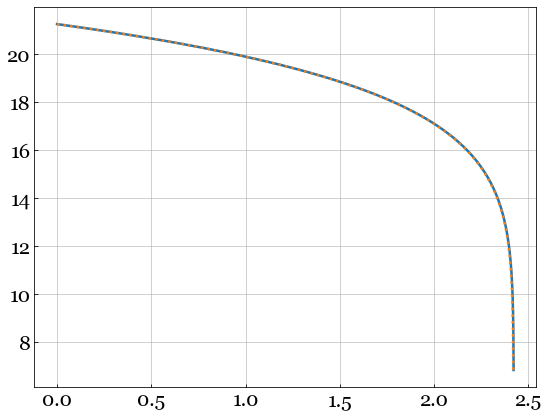

In [8]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot((t)/P_yr/1.e3, Li/St_unit)
ax.plot((t_scal)/P_yr/1.e3, L_scal/St_unit, ls=':')

In [9]:
Jx = Li_x + S1_x + S2_x
Jy = Li_y + S1_y + S2_y
Jz = Li_z + S1_z + S2_z
J = np.sqrt(Jx**2. + Jy**2. + Jz**2.)

St_x = S1_x + S2_x
St_y = S1_y + S2_y 
St_z = S1_z + S2_z
St = np.sqrt(St_x**2. + St_y**2. + St_z**2.)
St_unit = G*Mt**2./c

uS1_d_uLi = (S1_x*Li_x + S1_y*Li_y + S1_z*Li_z)/(S1 * Li)
uS2_d_uLi = (S2_x*Li_x + S2_y*Li_y + S2_z*Li_z)/(S2 * Li)
uS1_d_uS2 = (S1_x*S2_x + S1_y*S2_y + S1_z*S2_z)/(S1*S2)

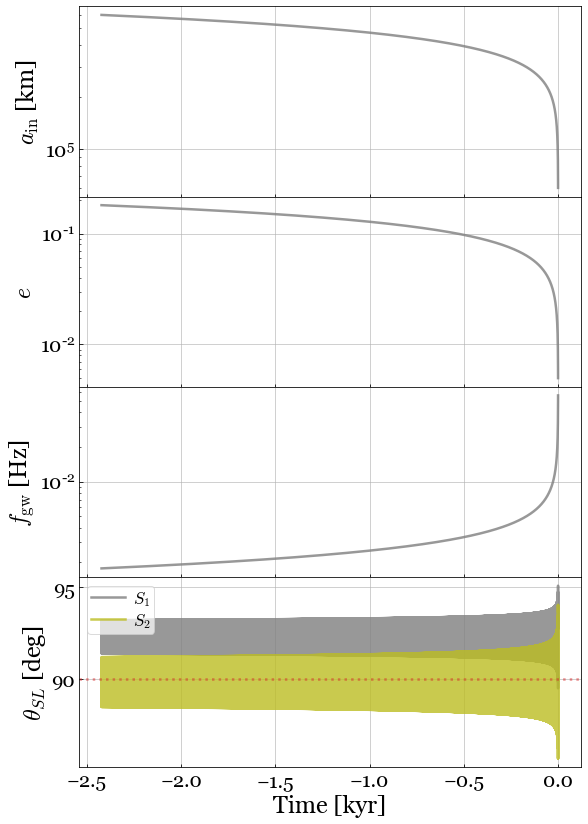

In [9]:
theta1_SL = np.real(np.arccos(\
        (S1_x*Li_x + S1_y*Li_y + S1_z*Li_z)/(S1*Li)+0j
                      ))
theta2_SL = np.real(np.arccos(\
        (S2_x*Li_x + S2_y*Li_y + S2_z*Li_z)/(S2*Li)+0j
                      ))
theta_SS = np.real(np.arccos(\
        (S1_x*S2_x + S1_y*S2_y + S1_z*S2_z)/(S1*S2)+0j
                    ))

omega_orb = np.sqrt(G*(M1+M2)/ai**3.)

fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(411)
ax.semilogy((t-t[-1])/P_yr/1.e3, ai/1.e5, alpha=0.8, color='tab:grey')
ax.set_ylabel(r'$a_{\rm in}$ [km]')
ax.set_xticklabels([])
ax=fig.add_subplot(412)
ax.semilogy((t-t[-1])/P_yr, ei, alpha=0.8, color='tab:grey')
ax.set_ylabel(r'$e$')
ax.set_xticklabels([])
ax=fig.add_subplot(413)
ax.semilogy((t-t[-1])/P_yr/1.e3, omega_orb/np.pi, alpha=0.8, color='tab:grey')
ax.set_ylabel(r'$f_{\rm gw}$ [Hz]')
ax.set_xticklabels([])
ax=fig.add_subplot(414)
ax.plot((t-t[-1])/P_yr/1.e3, theta1_SL*180./np.pi, alpha=0.8, label=r'$S_1$', color='tab:grey')
ax.plot((t-t[-1])/P_yr/1.e3, theta2_SL*180./np.pi, alpha=0.8, label=r'$S_2$', color='tab:olive')
ax.axhline(90., color='tab:red', ls=':', alpha=0.5)
ax.set_ylabel(r'$\theta_{SL}$ [deg]')
ax.legend(loc='upper left')
ax.set_xlabel(r'Time [kyr]')

# ax=fig.add_subplot(414)
# ax.plot(t-t[-1], theta_SS*180./np.pi, alpha=0.8, color='tab:grey')
# ax.set_ylabel(r'$\theta_{SS}$ [deg]')
# ax.set_xlabel(r'Time')

plt.subplots_adjust(hspace=0)
# plt.savefig(fig_dir+prefix+'evol.pdf')

-0.015999164101406907


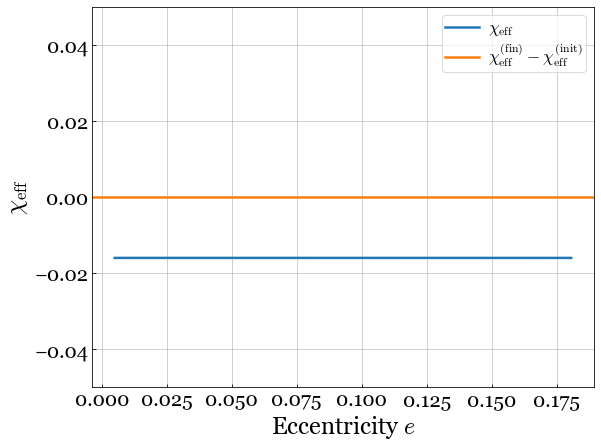

In [10]:
chi_eff = (M1*uS1_d_uLi*chi1 + M2*uS2_d_uLi*chi2)/(M1+M2)
print(np.median(chi_eff))
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(ei, chi_eff, label=r'$\chi_{\rm eff}$')
ax.axhline(chi_eff[-1] - chi_eff[0], \
           ls='-', color='tab:orange', \
           label=r'$\chi_{\rm eff}^{\rm(fin)} - \chi_{\rm eff}^{\rm (init)}$')
ax.set_ylim([-0.05, 0.05])
# ax.set_xlim([0.877, 0.983])
ax.legend(loc='upper right')
ax.set_xlabel(r'Eccentricity $e$')
ax.set_ylabel(r'$\chi_{\rm eff}$')
# fig.savefig(fig_dir + 'chi_eff_vs_e.pdf')

chi_eff=np.median(chi_eff)

In [ ]:
# c_th1 = 0.5 * 1./((1.-qq)*S1) * \
#         ((J**2. - Li**2. - St**2.)/Li  - 2.*qq*G*Mt**2./c*chi_eff/(1.+qq))
# c_th2 = 0.5 * qq/((1.-qq)*S2) * \
#         (-(J**2.-Li**2.-St**2.)/Li + 2.*G*Mt**2./c*chi_eff/(1.+qq))
# c_th12 = (St**2. - S1**2. -S2**2.)/(2.*S1*S2)
# c_dphi = (c_th12 - c_th1*c_th2)/(np.sin(np.arccos(c_th1)) * np.sin(np.arccos(c_th2)))


par = np.array([M1, M2, S1, S2, chi_eff])
th1, th2, th12, dphi = get_angles(J, Li, ei, St, par)
c_th1, c_th2, c_th12, c_dphi \
    = np.cos(th1), np.cos(th2), np.cos(th12), np.cos(dphi)

# for i in range(len(ei)):
#     JLSe_vect = np.array([J[i], Li[i], St[i], ei[i]]) 
#     th1, th2, th12, dphi = get_angles(JLSe_vect, par)
#     c_th1[i], c_th2[i], c_th12[i], c_dphi[i] \
#         = np.cos(th1), np.cos(th2), np.cos(th12), np.cos(dphi)


fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(311)
ax.plot(ei, c_th1, label=r'Kesden+15, Eq. (7)', alpha=0.3)
ax.plot(ei, c_th1 - uS1_d_uLi, label=r'Difference')
ax.legend(loc='center right')
ax.set_ylabel(r'$\cos\theta_1$')
# ax.set_xlim([0.877, 0.983])
ax.set_xticklabels([])

ax=fig.add_subplot(312)
ax.plot(ei, c_th2, alpha=0.3)
ax.plot(ei, c_th2 - uS2_d_uLi)
ax.set_ylabel(r'$\cos\theta_2$')
# ax.set_xlim([0.877, 0.983])
ax.set_xticklabels([])

ax=fig.add_subplot(313)
ax.plot(ei, c_th12, alpha=0.3)
ax.plot(ei, c_th12 - uS1_d_uS2)
ax.set_ylabel(r'$\cos\theta_{12}$')
ax.set_xlabel(r'Eccentricity $e$')
# ax.set_xlim([0.877, 0.983])

fig.subplots_adjust(hspace=0.05)
# fig.savefig(fig_dir + 'ang_vs_e.pdf')

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in arccos


In [ ]:
dSt_dt_num = np.gradient(St)/np.gradient(t) / (Mt * c)
dSt_dt = get_dSdt(J, Li, ei, St, par) / (Mt * c)

dSt_dt_ref = - 1.5 * (1.-qq**2.)/qq * eta**6.*eff_i**3. \
        * S1*S2/St * (G*Mt**2./c/Li)**5. * (c**3./G/Mt) \
        * (1.-eta*G*Mt**2./c/Li*chi_eff)\
        * np.sin(th1) * np.sin(th2) * np.sin(dphi)\
        /(Mt * c)

# print(S1*S2/St)
fig=plt.figure()
ax=fig.add_subplot(111)
# ax.plot(t, dSt_dt)
ax.plot(t[:10000], np.abs(dSt_dt_num/dSt_dt)[:10000], alpha=0.3, ls='', marker='.')
# ax.plot(t[:10000], np.abs(dSt_dt_num/dSt_dt_ref)[:10000], alpha=0.3, ls='', marker='.')
ax.set_ylim([0.5, 1.5])

In [16]:
omega_pre_ref = omega_orb * G*Mt/(c**2.*ai[-1]*eff_i[-1]**2.)
tau_pre_ref = 2.*np.pi/omega_pre_ref
tau_pre = get_tau_pre(J[-1], Li[-1], ei[-1], par, nPt=500)
print(tau_pre/tau_pre_ref)

[0.10798097 0.107981   0.10798103 ... 3.41457584 3.41462581 3.41465802]


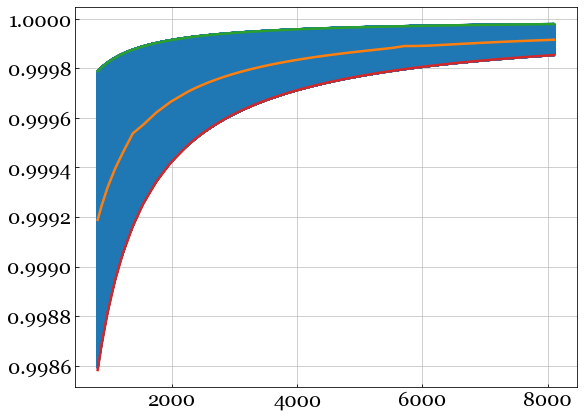

In [11]:
dJdL_num=J/Li * np.gradient(np.log(J))/np.gradient(np.log(Li))

par = np.array([M1, M2, S1, S2, chi_eff])

nPt=4000
int_func=lambda L_nat_, J_nat_:\
    evol_J_avg(L_nat_, J_nat_, e_vs_L_func, par, nPt=nPt)
    
sol=integ.solve_ivp(int_func, \
        t_span=(L_scal[0]/St_unit, L_scal[-1]/St_unit), y0=np.array([J[0]/St_unit]), rtol=1e-12, atol=1e-12)

LL = sol.t * St_unit
JJ = sol.y[0, :] * St_unit
dJdL = np.zeros(len(LL))
for i in range(len(LL)):
    dJdL[i] = evol_J_avg(LL[i]/St_unit, JJ[i]/St_unit, e_vs_L_func, par)
    
SSm, SSp=np.zeros([len(LL)]), np.zeros([len(LL)])
dJdLm, dJdLp=np.zeros([len(LL)]), np.zeros([len(LL)])
for i in range(len(LL)):
    SSm[i], SSp[i] = find_Smp(JJ[i], LL[i], e_vs_L_func(LL[i]), par, nPt)
    dJdLm[i] = (JJ[i]**2. + LL[i]**2. - SSm[i]**2.)/(2.*JJ[i]*LL[i])
    dJdLp[i] = (JJ[i]**2. + LL[i]**2. - SSp[i]**2.)/(2.*JJ[i]*LL[i])

ee = e_vs_L_func(LL)
aa = LL**2./(G*mu**2.*Mt*(1.-ee**2.))
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(ai/r_Mt, dJdL_num)
ax.plot(aa/r_Mt, dJdL)
ax.plot(aa/r_Mt, dJdLm)
ax.plot(aa/r_Mt, dJdLp)

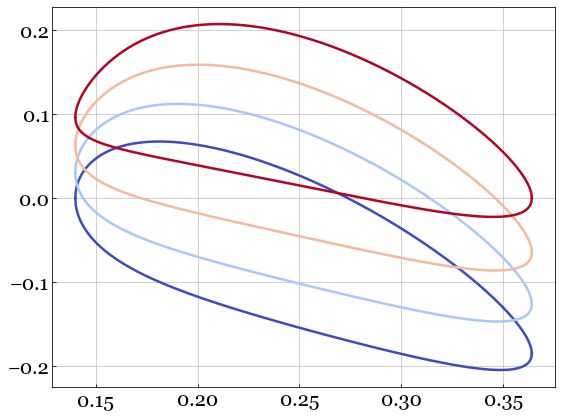

In [11]:
M1, M2 = 30.*Ms, 20.*Ms
Mt=M1+M2
mu=M1*M2/Mt
eta=mu/Mt

S_Mt=G*Mt**2./c
r_Mt=G*Mt/c**2.

chi1, chi2 = 0.7, 0.7
S1 = chi1 * G*M1**2./c
S2 = chi2 * G*M2**2./c

par = np.array([M1, M2, S1, S2, 0.])

LL = 0.5878774172949548*S_Mt
nJ = 4
JJ_min, JJ_max = np.sqrt(LL**2. + (S1-S2)**2.), np.sqrt(LL**2. + (S1+S2)**2.)
JJ = np.linspace(JJ_min, JJ_max, nJ)

nPt = 1000
S_vect = np.zeros([nJ, nPt])
chi_vect1 = np.zeros([nJ, nPt])
chi_vect2 = np.zeros([nJ, nPt])

for i in range(nJ):
    S_vect[i, :], chi_vect1[i, :], chi_vect2[i, :] \
        = find_S_chi_contour(JJ[i], LL, 0, par, nPt=nPt)

color=plt.cm.coolwarm(np.linspace(0, 1, nJ))

fig=plt.figure()
ax=fig.add_subplot(111)
for i in range(nJ):
    ax.plot(S_vect[i, :]/S_Mt, chi_vect1[i, :], color=color[i])
    ax.plot(S_vect[i, :]/S_Mt, chi_vect2[i, :], color=color[i])
    

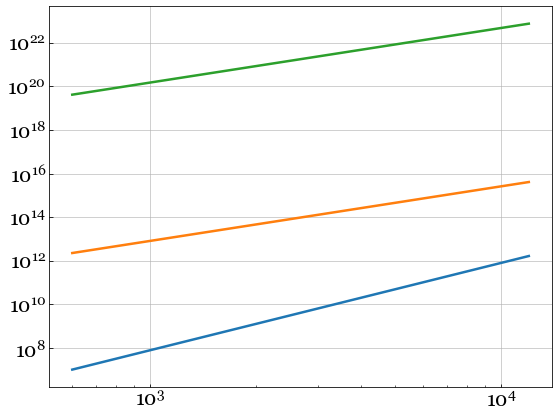

In [12]:
par = np.array([M1, M2, S1, S2, 0])
aa=np.logspace(np.log10(600*r_Mt), np.log10(12000*r_Mt), 1000)
LL=mu*np.sqrt(G*Mt*aa)

JJ1=np.sqrt(LL**2. + (S1+S2)**2.)
JJ2=np.sqrt(LL**2. + (S1-S2)**2.)

dSdt1 = get_dSdt(JJ1, LL, 0, S1+S2, par)
dSdt2 = get_dSdt(JJ2, LL, 0, np.abs(S1-S2), par)

tt_gw = get_inst_t_gw_from_a_orb(M1, M2, aa, 0)

tt_pre1 = np.abs((S1+S2)/dSdt1)
tt_pre2 = np.abs((S1-S2)/dSdt2)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.loglog(aa/r_Mt, tt_gw)
ax.loglog(aa/r_Mt, tt_pre1)
ax.loglog(aa/r_Mt, tt_pre2)

In [ ]:
Leinonen, Waltteri
Lekhwani, Rohan
Gao, Bore
Sengupta, Aditya
Li, Yilin